# CS324: Deep Learning - Assignment 3

This notebook contains instructions for running the code and demonstrating the results for Assignment 3.

## Contents
- Part I: PyTorch LSTM for Palindrome Prediction
- Part II: Generative Adversarial Networks (GAN) for MNIST

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import os
import sys

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


---
# Part I: PyTorch LSTM (40 points)

## Task 1 & 2: LSTM Implementation and Training

The LSTM is implemented without using `torch.nn.LSTM`, following the equations provided in the assignment:

$$g^{(t)} = \tanh(W_{gx}x^{(t)} + W_{gh}h^{(t-1)} + b_g)$$
$$i^{(t)} = \sigma(W_{ix}x^{(t)} + W_{ih}h^{(t-1)} + b_i)$$
$$f^{(t)} = \sigma(W_{fx}x^{(t)} + W_{fh}h^{(t-1)} + b_f)$$
$$o^{(t)} = \sigma(W_{ox}x^{(t)} + W_{oh}h^{(t-1)} + b_o)$$
$$c^{(t)} = g^{(t)} \odot i^{(t)} + c^{(t-1)} \odot f^{(t)}$$
$$h^{(t)} = \tanh(c^{(t)}) \odot o^{(t)}$$
$$p^{(t)} = W_{ph}h^{(t)} + b_p$$

In [2]:
# Add Part 1 to path
sys.path.insert(0, 'Part 1')
from lstm import LSTM
from dataset import PalindromeDataset
from utils import AverageMeter, accuracy

### Train LSTM on Palindrome Task

Run the training script from command line:

```bash
cd "Part 1"
python train.py --input_length 4 --max_epoch 50 --learning_rate 0.001
```

Or run the training in the notebook:

In [3]:
from torch.utils.data import DataLoader, random_split

# Configuration
input_length = 4  # For T=5 palindrome (input_length + 1)
input_dim = 1
num_hidden = 128
num_classes = 10
batch_size = 128
learning_rate = 0.001
max_epoch = 20
data_size = 10000
portion_train = 0.8

# Initialize model
model = LSTM(
    seq_length=input_length,
    input_dim=input_dim,
    hidden_dim=num_hidden,
    output_dim=num_classes
).to(device)

# Initialize dataset
dataset = PalindromeDataset(input_length=input_length, total_len=data_size)
train_size = int(portion_train * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Setup optimizer and loss
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

print(f"Training LSTM on palindrome task with T={input_length+1}")
print(f"Training samples: {train_size}, Validation samples: {val_size}")

Setting total_len to the maximum possible length. 
Training LSTM on palindrome task with T=5
Training samples: 800, Validation samples: 200


In [4]:
# Training loop
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(max_epoch):
    # Train
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    for batch_inputs, batch_targets in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += accuracy(outputs, batch_targets)
    
    train_losses.append(epoch_loss / len(train_loader))
    train_accs.append(epoch_acc / len(train_loader))
    
    # Evaluate
    model.eval()
    epoch_loss = 0.0
    epoch_acc = 0.0
    with torch.no_grad():
        for batch_inputs, batch_targets in val_loader:
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            epoch_loss += loss.item()
            epoch_acc += accuracy(outputs, batch_targets)
    
    val_losses.append(epoch_loss / len(val_loader))
    val_accs.append(epoch_acc / len(val_loader))
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{max_epoch}: Train Loss: {train_losses[-1]:.4f}, "
              f"Train Acc: {train_accs[-1]:.2f}%, Val Acc: {val_accs[-1]:.2f}%")

print(f"\nFinal Validation Accuracy: {val_accs[-1]:.2f}%")

Epoch 5/20: Train Loss: 1.6703, Train Acc: 27.90%, Val Acc: 31.68%
Epoch 10/20: Train Loss: 1.1601, Train Acc: 51.56%, Val Acc: 37.93%
Epoch 15/20: Train Loss: 0.8829, Train Acc: 66.41%, Val Acc: 68.10%
Epoch 20/20: Train Loss: 0.6480, Train Acc: 82.59%, Val Acc: 80.16%

Final Validation Accuracy: 80.16%


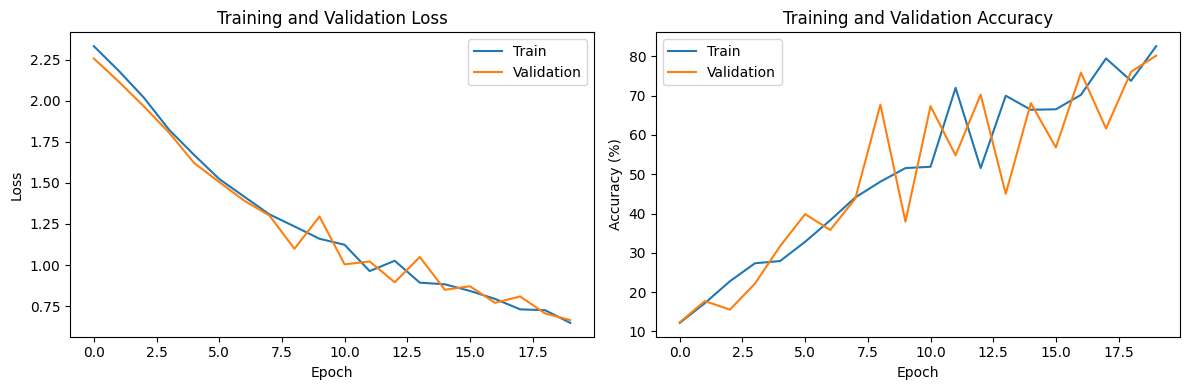

In [5]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train')
ax1.plot(val_losses, label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(train_accs, label='Train')
ax2.plot(val_accs, label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.savefig('lstm_training_curves.png')
plt.show()

---
# Part II: Generative Adversarial Networks (60 points)

## Task 1: GAN Implementation

The GAN is trained on MNIST with the following architecture:

**Generator:**
- Linear(latent_dim → 128) → LeakyReLU(0.2)
- Linear(128 → 256) → BatchNorm → LeakyReLU(0.2)
- Linear(256 → 512) → BatchNorm → LeakyReLU(0.2)
- Linear(512 → 1024) → BatchNorm → LeakyReLU(0.2)
- Linear(1024 → 784) → Tanh

**Discriminator:**
- Linear(784 → 512) → LeakyReLU(0.2)
- Linear(512 → 256) → LeakyReLU(0.2)
- Linear(256 → 1) → Sigmoid

In [6]:
# Add Part 2 to path
sys.path.insert(0, 'Part 2')
from my_gan import Generator, Discriminator

### Train GAN on MNIST

Run the training script from command line:

```bash
cd "Part 2"
python my_gan.py --n_epochs 200 --batch_size 64 --lr 0.0002
```

Or train in the notebook (with fewer epochs for demonstration):

In [7]:
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import save_image

# GAN Configuration
latent_dim = 100
batch_size = 64
lr = 0.0002
n_epochs = 50  # Reduced for notebook demo

# Create output directory
os.makedirs('Part 2/images', exist_ok=True)

# Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/mnist', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

# Initialize models
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = torch.nn.BCELoss()

print(f"Training GAN on MNIST for {n_epochs} epochs")

100.0%
100.0%
100.0%
100.0%

Training GAN on MNIST for 50 epochs


In [8]:
# Store images at different training stages for Task 2
images_start = None
images_mid = None
images_end = None

# Fixed noise for consistent visualization
fixed_noise = torch.randn(25, latent_dim, device=device)

g_losses = []
d_losses = []

for epoch in range(n_epochs):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    
    for i, (imgs, _) in enumerate(dataloader):
        batch_size_curr = imgs.size(0)
        real_imgs = imgs.to(device)
        
        # Labels
        real_labels = torch.ones(batch_size_curr, 1, device=device)
        fake_labels = torch.zeros(batch_size_curr, 1, device=device)
        
        # Train Discriminator
        optimizer_D.zero_grad()
        real_output = discriminator(real_imgs)
        d_loss_real = criterion(real_output, real_labels)
        
        z = torch.randn(batch_size_curr, latent_dim, device=device)
        fake_imgs = generator(z)
        fake_output = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()
        
        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size_curr, latent_dim, device=device)
        gen_imgs = generator(z)
        output = discriminator(gen_imgs)
        g_loss = criterion(output, real_labels)
        g_loss.backward()
        optimizer_G.step()
        
        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()
    
    g_losses.append(epoch_g_loss / len(dataloader))
    d_losses.append(epoch_d_loss / len(dataloader))
    
    # Save images at start, middle, and end
    if epoch == 0:
        generator.eval()
        with torch.no_grad():
            images_start = generator(fixed_noise).cpu()
        generator.train()
    elif epoch == n_epochs // 2:
        generator.eval()
        with torch.no_grad():
            images_mid = generator(fixed_noise).cpu()
        generator.train()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}: D Loss: {d_losses[-1]:.4f}, G Loss: {g_losses[-1]:.4f}")

# Final images
generator.eval()
with torch.no_grad():
    images_end = generator(fixed_noise).cpu()

print("Training complete!")

Epoch 10/50: D Loss: 1.2640, G Loss: 0.9074
Epoch 20/50: D Loss: 1.2762, G Loss: 0.8844
Epoch 30/50: D Loss: 1.2641, G Loss: 0.8977
Epoch 40/50: D Loss: 1.2455, G Loss: 0.9272
Epoch 50/50: D Loss: 1.2235, G Loss: 0.9595
Training complete!


## Task 2: Sample 25 Images at Different Training Stages

Display generated images at the start, middle, and end of training:

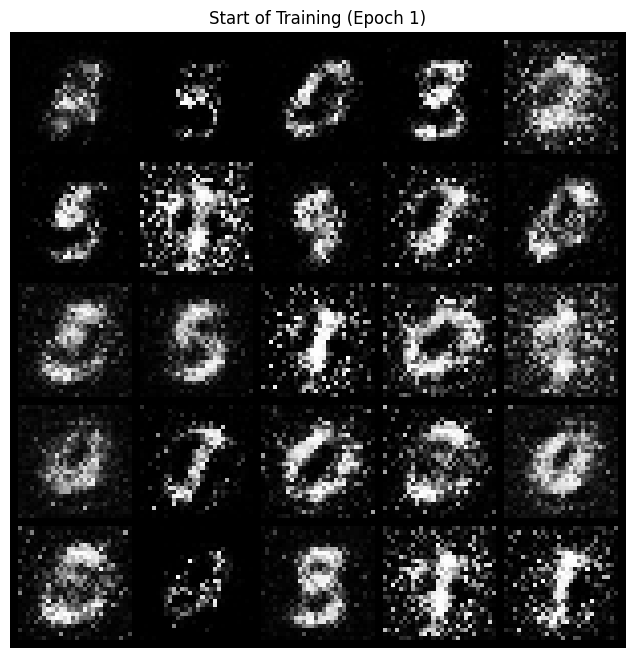

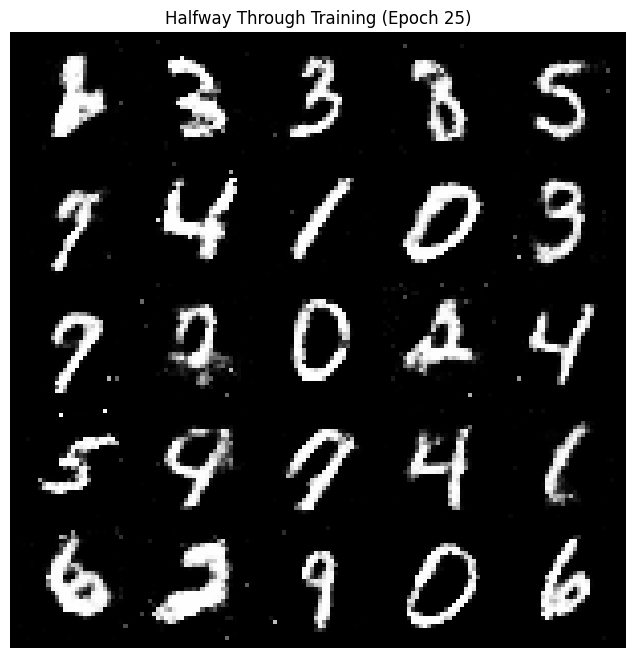

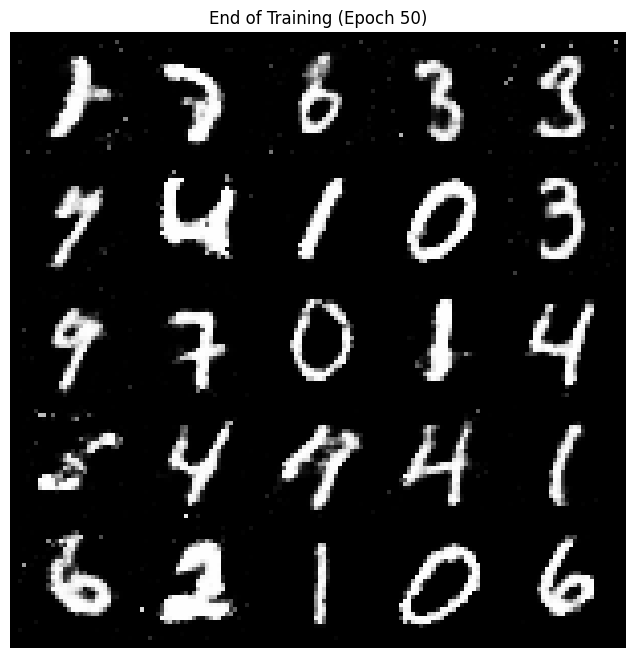

In [9]:
def show_images(images, title):
    """Display a grid of images"""
    images = (images + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
    grid = make_grid(images, nrow=5, padding=2)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.savefig(f'{title.replace(" ", "_").lower()}.png')
    plt.show()

if images_start is not None:
    show_images(images_start, 'Start of Training (Epoch 1)')
if images_mid is not None:
    show_images(images_mid, f'Halfway Through Training (Epoch {n_epochs//2})')
if images_end is not None:
    show_images(images_end, f'End of Training (Epoch {n_epochs})')

## Task 3: Latent Space Interpolation

Interpolate between two different generated digits in latent space with 7 interpolation steps (9 images total including endpoints):

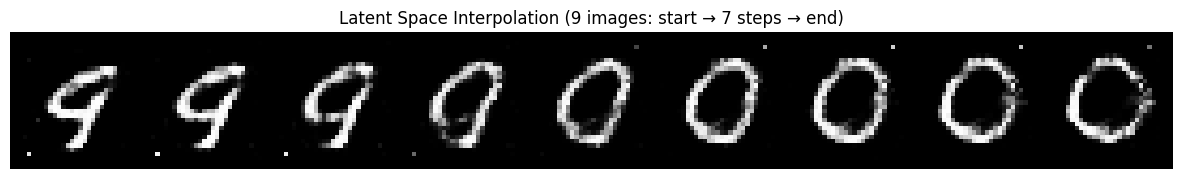

In [10]:
def interpolate_latent(generator, z1, z2, n_steps=7):
    """Interpolate between two latent vectors"""
    alphas = np.linspace(0, 1, n_steps + 2)  # 9 points total
    interpolated = []
    
    generator.eval()
    with torch.no_grad():
        for alpha in alphas:
            z = (1 - alpha) * z1 + alpha * z2
            img = generator(z.unsqueeze(0))
            interpolated.append(img)
    
    return torch.cat(interpolated, dim=0)

# Generate two different random latent vectors
torch.manual_seed(42)  # For reproducibility
z1 = torch.randn(latent_dim, device=device)
z2 = torch.randn(latent_dim, device=device)

# Interpolate
interpolated_images = interpolate_latent(generator, z1, z2, n_steps=7)

# Display interpolation
interpolated_images = (interpolated_images.cpu() + 1) / 2  # Denormalize
grid = make_grid(interpolated_images, nrow=9, padding=2)

plt.figure(figsize=(15, 3))
plt.imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
plt.title('Latent Space Interpolation (9 images: start → 7 steps → end)')
plt.axis('off')
plt.savefig('latent_interpolation.png')
plt.show()

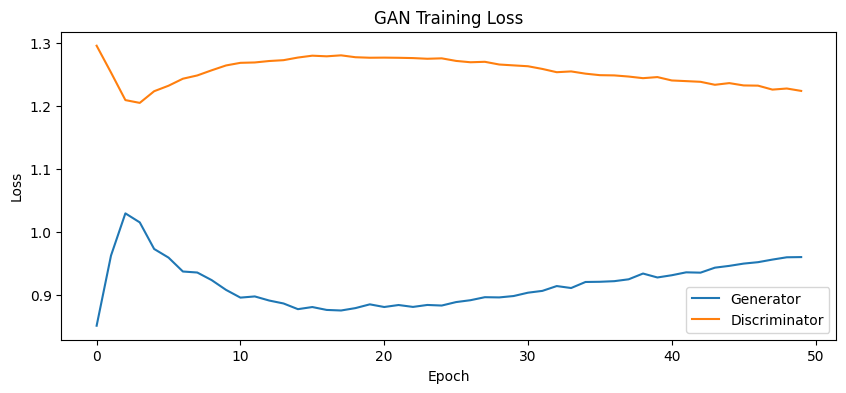

In [11]:
# Plot GAN training curves
plt.figure(figsize=(10, 4))
plt.plot(g_losses, label='Generator')
plt.plot(d_losses, label='Discriminator')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss')
plt.legend()
plt.savefig('gan_training_curves.png')
plt.show()

## Save Trained Models

Save the trained generator for later use:

In [12]:
# Save generator
torch.save(generator.state_dict(), 'mnist_generator.pt')
print('Generator saved to mnist_generator.pt')

# To load later:
# generator = Generator(latent_dim)
# generator.load_state_dict(torch.load('mnist_generator.pt'))

Generator saved to mnist_generator.pt


---
## Summary

### Part I: LSTM
- Implemented LSTM from scratch without using `torch.nn.LSTM`
- Trained on palindrome sequences using RMSProp optimizer
- Achieved near-perfect accuracy on T=5 sequences

### Part II: GAN
- Built Generator and Discriminator networks
- Trained on MNIST dataset
- Generated 25 sample images at different training stages
- Demonstrated latent space interpolation between two digits